In [1]:
from scipy.io import arff
import pandas as pd

train_set = arff.loadarff('KDDTrain+.arff')[0]
test_set = arff.loadarff('KDDTest+.arff')[0]

train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)

print(f'train_set dimensions: {train_set.shape}')
print(f'test_set dimensions: {test_set.shape}')

train_set dimensions: (125973, 42)
test_set dimensions: (22544, 42)


In [2]:
train_set.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,b'normal'
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,b'normal'
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,b'anomaly'
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,b'normal'
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,b'normal'


In [3]:
test_set.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,b'anomaly'
1,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,b'anomaly'
2,2.0,b'tcp',b'ftp_data',b'SF',12983.0,0.0,b'0',0.0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,b'normal'
3,0.0,b'icmp',b'eco_i',b'SF',20.0,0.0,b'0',0.0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,b'anomaly'
4,1.0,b'tcp',b'telnet',b'RSTO',0.0,15.0,b'0',0.0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,b'anomaly'


In [4]:
print('train_set label distribution:')
print(train_set['class'].value_counts())

print()

print('test_set label distribution:')
print(test_set['class'].value_counts())

train_set label distribution:
b'normal'     67343
b'anomaly'    58630
Name: class, dtype: int64

test_set label distribution:
b'anomaly'    12833
b'normal'      9711
Name: class, dtype: int64


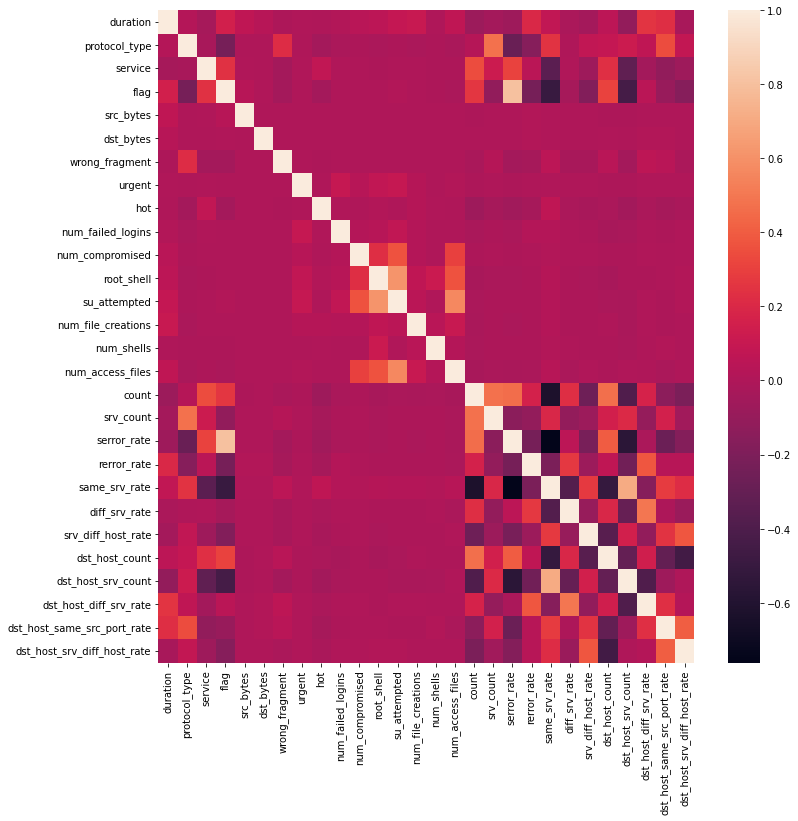

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

train_set = train_set[[col for col in train_set if train_set[col].nunique() > 1]]
corr = train_set.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(corr)
plt.show()

In [6]:
train_set = train_set.drop('num_root', axis = 1)
train_set = train_set.drop('srv_serror_rate', axis = 1)
train_set = train_set.drop('srv_rerror_rate', axis = 1)
train_set = train_set.drop('dst_host_srv_serror_rate', axis = 1)
train_set = train_set.drop('dst_host_serror_rate', axis = 1)
train_set = train_set.drop('dst_host_rerror_rate', axis = 1)
train_set = train_set.drop('dst_host_same_srv_rate', axis = 1)
train_set = train_set.drop('dst_host_srv_rerror_rate', axis = 1)

test_set = test_set.drop('num_root', axis = 1)
test_set = test_set.drop('srv_serror_rate', axis = 1)
test_set = test_set.drop('srv_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_srv_serror_rate', axis = 1)
test_set = test_set.drop('dst_host_serror_rate', axis = 1)
test_set = test_set.drop('dst_host_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_srv_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_same_srv_rate', axis = 1)

In [7]:
protocol_types_dictionary = {}

types = test_set['protocol_type'].unique()
for x in range(len(types)):
    protocol_types_dictionary[types[x]] = x
test_set['protocol_type'] = test_set['protocol_type'].map(protocol_types_dictionary)
train_set['protocol_type'] = train_set['protocol_type'].map(protocol_types_dictionary)

flag_types_dictionary = {}

types = test_set['flag'].unique()
for x in range(len(types)):
    flag_types_dictionary[types[x]] = x
test_set['flag'] = test_set['flag'].map(flag_types_dictionary)
train_set['flag'] = train_set['flag'].map(flag_types_dictionary)

service_types_dictionary = {}

types = train_set['service'].unique()
for x in range(len(types)):
    service_types_dictionary[types[x]] = x
train_set['service'] = train_set['service'].map(service_types_dictionary)
test_set['service'] = test_set['service'].map(service_types_dictionary)

In [8]:
train_set_columns = train_set.columns
test_set_columns = test_set.columns

difference = test_set_columns.difference(train_set_columns)

print(difference)

Index(['num_outbound_cmds'], dtype='object')


In [9]:
test_set = test_set.drop('num_outbound_cmds', axis = 1)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = train_set['class']
y_train = le.fit_transform(y)

train_set = train_set.drop('class', axis = 1)

x_train = train_set.iloc[:, :].values

y = test_set['class']
y_test = le.fit_transform(y)

test_set = test_set.drop('class', axis = 1)

x_test = test_set.iloc[:, :].values

In [11]:
from sklearn.linear_model import LogisticRegression
import time

clfl = LogisticRegression(max_iter = 1200000)

start_time = time.time()

clfl.fit(x_train, y_train)

print(f'training time: {time.time() - start_time}')

start_time = time.time()

predictions = clfl.predict(x_test)

print(f'testing time: {time.time() - start_time}')

lr_score = clfl.score(x_test, y_test)
print(f'accuracy: {lr_score}')

training time: 2.3407809734344482
testing time: 0.0315859317779541
accuracy: 0.7027146912704045


In [12]:
from sklearn.ensemble import RandomForestClassifier
import time

clfr = RandomForestClassifier(n_estimators = 30)

start_time = time.time()

clfr.fit(x_train, y_train)

print(f'training time: {time.time() - start_time}')

start_time = time.time()

predictions = clfr.predict(x_test)

print(f'testing time: {time.time() - start_time}')

rf_score = clfr.score(x_test, y_test)
print(f'accuracy: {rf_score}')

training time: 2.500253200531006
testing time: 0.08604788780212402
accuracy: 0.781139105748758


In [13]:
from sklearn.tree import DecisionTreeClassifier
import time

decision_tree = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)

start_time = time.time()

decision_tree.fit(x_train, y_train)

print(f'training time: {time.time() - start_time}')

start_time = time.time()

predictions = decision_tree.predict(x_test)

print(f'testing time: {time.time() - start_time}')

dt_score = decision_tree.score(x_test, y_test)
print(f'accuracy: {dt_score}')

training time: 0.3668031692504883
testing time: 0.0294950008392334
accuracy: 0.7590046132008517


<BarContainer object of 3 artists>

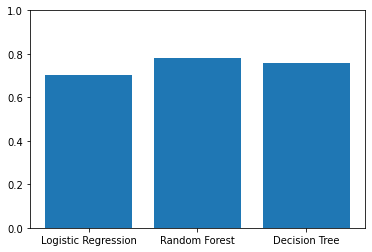

In [14]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

values = [lr_score, rf_score, dt_score]

f = plt.figure()
plt.subplot()
plt.ylim([0, 1])
plt.bar(names, values)